In [1]:
import numpy as np 
import pandas as pd
from pathlib import Path
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os
parent_dir = os.path.abspath("../papers/Attention Is All You Need")
sys.path.append(parent_dir)
%load_ext autoreload
%autoreload 

In [2]:
PATH = Path("../../../")  / "data" / "EnglishGerman" 

In [3]:
dataset = pd.read_csv(PATH / "wmt14_translate_de-en_validation.csv")

## Train Tokeniser

In [11]:
def encode_utf8(words): 
    utf = [word.encode("utf-8") for word in words]
    tokens = [list(map(int, u)) for u in utf]
    return tokens

def get_pair_counts(word):
    return dict(Counter(zip(word[:-1], word[1:])))

def sum_dicts(dicts):
    def reducer(accumulator, element):
        for key, value in element.items():
            accumulator[key] = accumulator.get(key, 0) + value
        return accumulator
    return reduce(reducer, dicts, {})

def get_vocab_pairing(sentences):
    pair_counts = [get_pair_counts(sentence) for sentence in sentences]
    return sum_dicts(pair_counts)

In [12]:
def get_merged_pairs(german_encode, english_encode):
    german_pairs = get_vocab_pairing(german_encode)
    english_pairs = get_vocab_pairing(english_encode)
    return sum_dicts([german_pairs, english_pairs])

In [20]:
german_encode = encode_utf8(dataset.iloc[: , 0].to_list())
english_encode = encode_utf8(dataset.iloc[: , 1].to_list())
sum_encode = encode_utf8(dataset.iloc[: , 1].to_list() + dataset.iloc[: , 0].to_list())

In [21]:
get_vocab_pairing(sum_encode) == get_merged_pairs(english_encode, german_encode)

True

In [31]:
def replace_encodings(encoding, pair, new_idx):
    new_encoding = []
    i = 0
    while i < len(encoding):
        if i < len(encoding) - 1 and encoding[i] == pair[0] and encoding[i + 1] == pair[1]:
            new_encoding.append(new_idx)
            i += 2
        else: 
            new_encoding.append(encoding[i])
            i += 1
    return new_encoding

def merge_stats(german_encode, english_encode, max_vocab_size):
    merges = {}
    curr_max = 256
    L = [] # this is just for statistics
    while (curr_max - 255 <= max_vocab_size):
        if ((curr_max - 255) % 10 == 0):
            print(curr_max - 255)
        stats = get_merged_pairs(german_encode=german_encode, english_encode=english_encode)
        top_pair = max(stats, key=stats.get)
        if stats[top_pair] == 1: # we dont have any merges left
            return merges, L
        else:
            german_encode = list(map(lambda enc: replace_encodings(enc, top_pair, curr_max), german_encode))
            english_encode = list(map(lambda enc: replace_encodings(enc, top_pair, curr_max), english_encode))
            merges[(top_pair)] = curr_max
            curr_max += 1
            L.append(reduce(lambda a, b: a + len(b), german_encode + english_encode, 0))
    return merges, L


def merge(german_encode, english_encode, max_vocab_size):
    merges = {}
    curr_max = 256
    while (curr_max - 255 <= max_vocab_size):
        stats = get_merged_pairs(german_encode=german_encode, english_encode=english_encode)
        top_pair = max(stats, key=stats.get)
        if stats[top_pair] == 1: # we dont have any merges left
            return merges
        else:
            german_encode = list(map(lambda enc: replace_encodings(enc, top_pair, curr_max), german_encode))
            english_encode = list(map(lambda enc: replace_encodings(enc, top_pair, curr_max), english_encode))
            merges[(top_pair)] = curr_max
            curr_max += 1
    return merges

In [10]:
merges, new_tokens =  merge_stats(german_encode, english_encode, 20000)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

## Compression Ratio

In [13]:
old = reduce(lambda a, b: a + len(b), german_encode + english_encode, 0)

Text(0, 0.5, 'compression ratio')

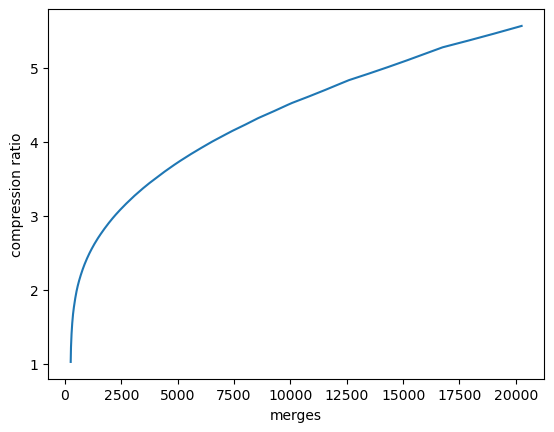

In [85]:
plt.plot(255 + np.arange(1, len(new_tokens) + 1), old / np.array(new_tokens))
plt.xlabel("merges")
plt.ylabel("compression ratio")

We can see even with a small amount of merges like 2500, we get a compression ratio of 3 and so limitng ourselves to small vocab size will be sufficient for training the transformer.

## Inference Time

In [71]:
def decode(encoding, vocab_reverse):
    
    def __one_decode(sentence):
        original_text = []
        while True:
            non_seen = True
            for byte in sentence:
                if byte in vocab_reverse:
                    original_text.append(vocab_reverse[byte][0])
                    original_text.append(vocab_reverse[byte][1])
                    non_seen = False
                else: 
                    original_text += [byte]
            if non_seen:

                return bytes(original_text).decode("utf-8", errors="replace")
            else: 
                sentence = original_text
                original_text = []
    return list(map(__one_decode, encoding))


In [67]:
def encode(text, vocab):
    utf8_encoding = encode_utf8(text)
    while True:
        stats = get_vocab_pairing(utf8_encoding)
        pair = min(stats, key = lambda p: vocab.get(p, float("inf")))
        if pair not in vocab:
            break
        idx = vocab[pair]
        utf8_encoding = list(map(lambda enc: replace_encodings(enc, pair, idx), utf8_encoding))
    return utf8_encoding

In [75]:
(decode(encode(["Hello this is a random string"], merges), {v: k for k,v in merges.items()}))

['Hello this is a random string']

In [88]:
merges_final =  merge(german_encode, english_encode, 2500)

## Using Imports

In [5]:
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 858.6 kB/s eta 0:00:00a 0:00:01


In [2]:
from BPE.bpe import BPEEncoder, BPEDecoder 

In [16]:
train_english = pd.read_table("../data/en-hi/train.en", header=None, nrows=500_000)
train_hindi = pd.read_table("../data/en-hi/train.hi", header=None, nrows=500_000)

In [4]:
encoder = BPEEncoder(train_set=train_english.iloc[:, 0].to_list() + train_hindi.iloc[: , 0].to_list())
encoder.train(2500)

256
257
258
259
260
261
262
263
264
265
266
267


KeyboardInterrupt: 

## Using SentencePiece (for faster)

In [7]:
combined = pd.concat([train_english, train_hindi], ignore_index=True)
combined.to_csv("../data/en-hi/combined_small.txt", index=False, header=False)

In [17]:
train_hindi.to_csv("../data/en-hi/hindi_small_train.txt", index=False, header=False)
train_english.to_csv("../data/en-hi/english_small_train.txt", index=False, header=False)

In [4]:
import sentencepiece as spm

In [18]:
spm.SentencePieceTrainer.train(input=['../data/en-hi/hindi_small_train.txt', '../data/en-hi/english_small_train.txt'], model_prefix="en-hi", model_type='bpe', vocab_size=8000, pad_id=3, bos_piece="<SOS>", eos_piece="<EOS>", unk_piece="<UNK>", pad_piece="<PAD>")

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../data/en-hi/hindi_small_train.txt
  input: ../data/en-hi/english_small_train.txt
  input_format: 
  model_prefix: en-hi
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <UNK>
  bos_piece: <SOS>
  eos_piece: <EOS>
  pad_piece: 

ded: freq=6648 size=1240 all=100406 active=7442 piece=▁गां
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6546 size=1260 all=101261 active=8297 piece=▁बद
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6465 size=1280 all=102399 active=9435 piece=der
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6319 size=1300 all=103752 active=10788 piece=▁दु
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=6307 min_freq=1116
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6198 size=1320 all=104762 active=6141 piece=ctions
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6122 size=1340 all=105784 active=7163 piece=ked
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6006 size=1360 all=107029 active=8408 piece=▁15
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5909 size=1380 all=107814 active=9193 piece=▁बैठ
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5792 size=1400 all=108871 active=10250 piece=▁आधार
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=5783 m

In [5]:
sp = spm.SentencePieceProcessor(model_file='../papers/Attention Is All You Need/BPE/en-hi.model')

In [89]:
sp.vocab_size()

8000

In [21]:
a = sp.encode_as_ids(train_hindi.iloc[:550_000, 0].to_list())
b = sp.encode_as_ids(train_english.iloc[:550_000, 0].to_list())

In [22]:
temp = 0
for l in a: 
    for num in l:
        if num == sp.unk_id():
            temp += 1

In [23]:
temp / sum([len(l) for l in a])

0.0017571000002892941

In [109]:
max([len(b) for b in a])

667

In [111]:
np.quantile([len(b) for b in a], q=0.99)

110.0

In [75]:
sp.eos_id()

2

In [22]:
train_hindi.iloc[10:20, 0].to_list()

['उन्होंने कहा, "बाबू रघुवंश प्रसाद जी ने भी गरीबों के लिए काम किया।',
 'इस विमान हादसे में सभी 176 यात्रियों की मौत हो गई थी.',
 'राहुल ने कहा, "मैं वही सवाल फिर से पूछता हूं।',
 'मीका ने यह बताया कि सच्ची उपासना कैसे उन लोगों को भी एक कर देगी जो पहले एक - दूसरे के दुश्\u200dमन थे ।',
 'आमंत्रित नहीं किया',
 '“ बड़ी भीड़ ” के ये लोग, अपनी तलवारों को पीटकर हल के फाल बनाते हुए, और इस तरह अपने संगी यहोवा के गवाहों के साथ शांति से जीकर ईश्\u200dवरीय न्याय के अनुरूप होते हैं ।',
 'सनी लियोन श्रृंखला में एक विशेषज्ञ की भूमिका निभाती हैं।',
 'इसके बाद जब य सुख जाए तो इसे साफ पानी से धो लें।',
 'भाटिया भारतीय जनता पार्टी के प्रवक्ता भी हैं।',
 'इसके जरिये ही हम देश का निर्माण करेंगे और उसे महान बना पायेंगे।']